Darcy Flow

In [1]:
# use the args from here: https://github.com/pdebench/PDEBench/blob/bf6a33b17cabe78a0c44df93d826b4cdee11740b/pdebench/models/config/config_darcy.yaml

# args:
#   model_name: 'FNO'
#   if_training: True
#   continue_training: False
#   num_workers: 2
#   batch_size: 50
#   initial_step: 1
#   t_train: 1     # steady-state
#   model_update: 2
#   filename: '2D_DarcyFlow_beta0.01_Train.hdf5'
#   single_file: True
#   reduced_resolution: 1
#   reduced_resolution_t: 1
#   reduced_batch: 1
#   epochs: 500
#   learning_rate: 1.e-3
#   scheduler_step: 100
#   scheduler_gamma: 0.5
#   #Unet
#   in_channels: 1
#   out_channels: 1
#   ar_mode: False
#   pushforward: False
#   unroll_step: 1
#   #FNO
#   num_channels: 1
#   modes: 12
#   width: 20
#   #Inverse
#   data_path: '../data/2D/DarcyFlow/Train/'
#   training_type: 'single'  #autoregressive
#   #Inverse MCMC
#   mcmc_num_samples: 20
#   mcmc_warmup_steps: 10
#   mcmc_num_chains: 1
#   num_samples_max: 1000
#   in_channels_hid: 64
#   inverse_model_type: InitialConditionInterp    
#   #Inverse grad
#   inverse_epochs: 100
#   inverse_learning_rate: 0.2
#   inverse_verbose_flag: False
#   #plotting
#   plot: False
#   channel_plot: 0 # Which channel/variable to be plotted
#   x_min: -1
#   x_max: 1    # spatial dimension x: [-1, 1]
#   y_min: -1
#   y_max: 1    # spatial dimension y: [-1, 1]
#   t_min: 0
#   t_max: 5    # time dimension t: [0, 5]

In [2]:
import os
import torch
import torch.nn
device = torch.device("cpu")
from pdebench.models.fno.fno import FNO1d, FNO2d, FNO3d
from pdebench.models.fno.utils import FNODatasetSingle
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
path="/Users/ajivani"
h5_file = h5py.File(os.path.join(path, "2D_DarcyFlow_beta10.0_Train.hdf5"), "r")
model_pt = os.path.join(path, "2D_DarcyFlow_beta10.0_Train_FNO.pt")

In [5]:
cfg = {
    "num_channels": 1, 
    "modes": 12,
    "width": 20,
    "initial_step": 1, 
}

In [6]:
reduced_resolution=1
reduced_resolution_t=1
reduced_batch=1

In [7]:
nb = 0
data = np.array(h5_file["tensor"], dtype=np.float32)[nb]
nu = np.array(h5_file["nu"], dtype=np.float32)[nb]

Text(0.5, 1.0, 'diffusion coefficient nu')

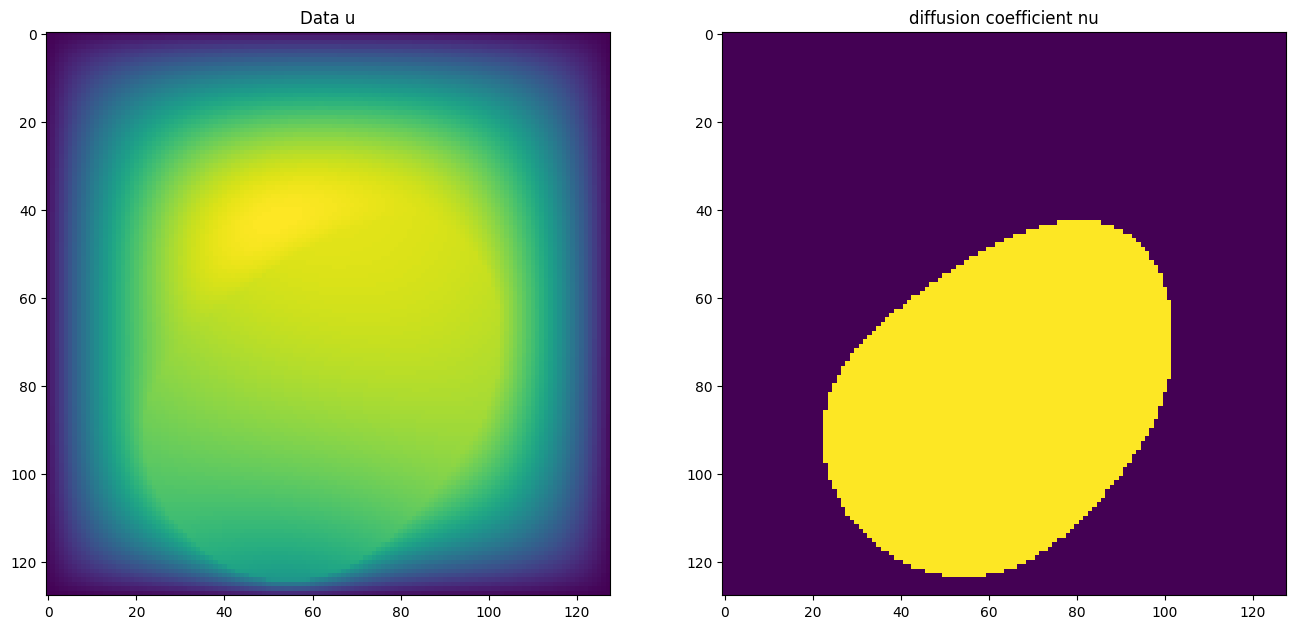

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(data.squeeze())
ax[1].imshow(nu.squeeze())
ax[0].set_title('Data u')
ax[1].set_title('diffusion coefficient nu')

In [9]:
data.shape

(1, 128, 128)

In [10]:
xcoord = np.array(h5_file["x-coordinate"], dtype=np.float32)
ycoord = np.array(h5_file["y-coordinate"], dtype=np.float32)

In [12]:
train_data = FNODatasetSingle("2D_DarcyFlow_beta10.0_Train.hdf5",
                                reduced_resolution=reduced_resolution,
                                reduced_resolution_t=reduced_resolution_t,
                                reduced_batch=reduced_batch,
                                initial_step=cfg["initial_step"],
                                if_test=True, # loading some test data instead
                                saved_folder = "/Users/ajivani/"
                                )

.HDF5 file extension is assumed hereafter


Now run it through original FNO model

In [13]:
model = FNO2d(
    num_channels=cfg["num_channels"],
    width=cfg["width"],
    modes1=cfg["modes"],
    modes2=cfg["modes"],
    initial_step=cfg["initial_step"]
).to(device)

model

FNO2d(
  (fc0): Linear(in_features=3, out_features=20, bias=True)
  (conv0): SpectralConv2d_fast()
  (conv1): SpectralConv2d_fast()
  (conv2): SpectralConv2d_fast()
  (conv3): SpectralConv2d_fast()
  (w0): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
# checkpoint = torch.load(model_pt, map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# model.to(device)

In [14]:
checkpoint = torch.load(model_pt, map_location=device)
checkpoint['model_state_dict']['fc0.weight'].shape

torch.Size([20, 3])

In [15]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=50,
                                               num_workers=1, shuffle=True)

In [16]:
_, _data, _ = next(iter(train_loader))

In [17]:
_data.shape

torch.Size([50, 128, 128, 2, 1])

In [18]:
dimensions = len(_data.shape)
print('Spatial Dimension', dimensions - 3)
dimensions

Spatial Dimension 2


5

In [ ]:
# transform data appropriately


In [19]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [20]:
# for xx, yy, grid in train_loader:
#             loss = 0
            
#             # xx: input tensor (first few time steps) [b, x1, ..., xd, t_init, v]
#             # yy: target tensor [b, x1, ..., xd, t, v]
#             # grid: meshgrid [b, x1, ..., xd, dims]
#             xx = xx.to(device)
#             yy = yy.to(device)
#             grid = grid.to(device)

In [21]:
xx, yy, grid = next(iter(train_loader))
xx.shape, yy.shape, grid.shape

(torch.Size([50, 128, 128, 1, 1]),
 torch.Size([50, 128, 128, 2, 1]),
 torch.Size([50, 128, 128, 2]))

In [22]:
initial_step=cfg["initial_step"]

In [23]:
pred = yy[..., :initial_step, :]

In [24]:
inp_shape = list(xx.shape)
inp_shape = inp_shape[:-2]
inp_shape.append(-1)

inp = xx.reshape(inp_shape)
y = yy[..., 1, :]
im = model(inp, grid)

In [25]:
y_orig = yy[..., [1], :]
y_orig.shape

torch.Size([50, 128, 128, 1, 1])

In [26]:
im.shape

torch.Size([50, 128, 128, 1, 1])

In [28]:
with torch.no_grad():
    sqd_err_orig = torch.nn.functional.mse_loss(y_orig, im)
sqd_err_orig

tensor(0.2334)

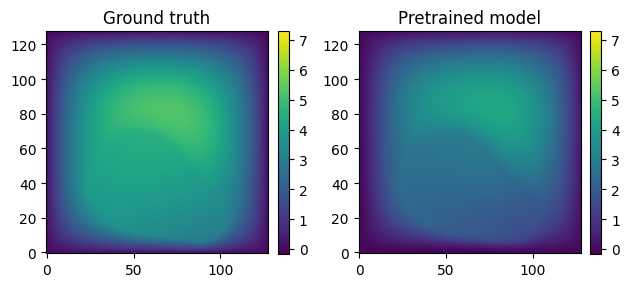

In [29]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
im0 = axs[0].imshow(y_orig[0, :, :, 0, 0].cpu().detach().numpy(), 
                    origin="lower",
                    vmin=-0.1672,
                    vmax=7.3099)
axs[0].set_title("Ground truth")
fig.colorbar(im0, fraction=0.046, pad=0.04)
im1 = axs[1].imshow(im[0, :, :, 0, 0].cpu().detach().numpy(), origin="lower",
                vmin=-0.1672,
                vmax=7.3099)
axs[1].set_title("Pretrained model")
fig.colorbar(im1, fraction=0.046, pad=0.04)
fig.tight_layout()

In [30]:
y_orig.min(), y_orig.max()

(tensor(0.0019), tensor(7.4737))

In [31]:
with torch.no_grad():
    print(im.min(), im.max())

tensor(-0.1490) tensor(6.5824)


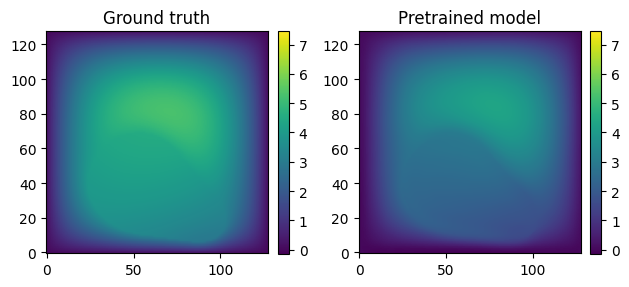

In [32]:
# def plot_result(res, ax):
#     plot_Y = res.cpu().detach().numpy()
#     im = ax.imshow(plot_Y, aspect=1)
    
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
im0 = axs[0].imshow(y_orig[0, :, :, 0, 0].cpu().detach().numpy(), 
                    origin="lower",
                    vmin=-0.1490,
                    vmax=7.4737)
axs[0].set_title("Ground truth")
fig.colorbar(im0, fraction=0.046, pad=0.04)
im1 = axs[1].imshow(im[0, :, :, 0, 0].cpu().detach().numpy(), origin="lower",
                vmin=-0.1490,
                vmax=7.4737)
axs[1].set_title("Pretrained model")
fig.colorbar(im1, fraction=0.046, pad=0.04)
fig.tight_layout()

In [33]:
import torch.nn as nn

In [34]:
import torch.quantization
quantized_model = torch.quantization.quantize_dynamic(
    model, {model.conv0, model.conv1, model.conv2, model.conv3, model.w0, model.w1, model.w2, model.w3, nn.Linear}, dtype=torch.qint8
)

In [35]:
quantized_model

FNO2d(
  (fc0): DynamicQuantizedLinear(in_features=3, out_features=20, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (conv0): SpectralConv2d_fast()
  (conv1): SpectralConv2d_fast()
  (conv2): SpectralConv2d_fast()
  (conv3): SpectralConv2d_fast()
  (w0): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (fc1): DynamicQuantizedLinear(in_features=20, out_features=128, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc2): DynamicQuantizedLinear(in_features=128, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [36]:
im_quant = quantized_model(inp, grid)

In [37]:
im_quant.shape

torch.Size([50, 128, 128, 1, 1])

In [38]:
with torch.no_grad():
    print(im_quant.min(), im_quant.max())

tensor(-0.1587) tensor(6.6039)


In [39]:
with torch.no_grad():
    sqd_err_qt = nn.functional.mse_loss(y_orig, im_quant)
sqd_err_qt

tensor(0.2251)

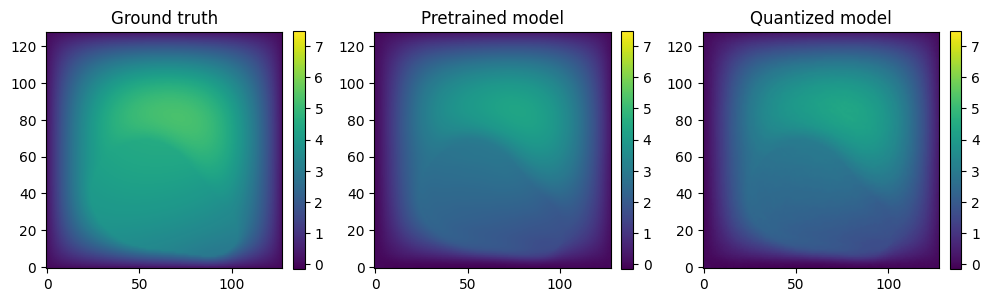

In [40]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(10, 6))
im0 = axs[0].imshow(y_orig[0, :, :, 0, 0].cpu().detach().numpy(), 
                    origin="lower",
                    vmin=-0.1494,
                    vmax=7.4737)
axs[0].set_title("Ground truth")
fig.colorbar(im0, fraction=0.046, pad=0.04)
im1 = axs[1].imshow(im[0, :, :, 0, 0].cpu().detach().numpy(), origin="lower",
                    vmin=-0.1494,
                    vmax=7.4737)

axs[1].set_title("Pretrained model")
fig.colorbar(im1, fraction=0.046, pad=0.04)

im2 = axs[2].imshow(im_quant[0, :, :, 0, 0].cpu().detach().numpy(), origin="lower",
                    vmin=-0.1494,
                    vmax=7.4737)

axs[2].set_title("Quantized model")
fig.colorbar(im2, fraction=0.046, pad=0.04)

fig.tight_layout()